In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision import transforms

In [ ]:
!pip install git+https://github.com/smitasasindran/eva5utils.git

In [3]:
from eva5utils.dataloaders import load_cifar10
from eva5utils.model import Model7, ResNet18
from eva5utils.transforms import model9_resnet_train_transforms, model9_resnet_test_transforms, model10_resnet_train_transforms
from eva5utils.train import train_loop
from eva5utils.test import test_loop
from eva5utils.utils import plot_samples, LRFinder, TrainDataLoaderIter, ValDataLoaderIter, plot_misclassified_gradcam, plot_train_vs_test
from eva5utils.utils.helpers import show_model_summary, DEVICE, IS_CUDA, accuracy_per_class, show_gradcam, find_misclassified

In [4]:
# Constants, put in config
epochs = 50
cuda_batch_size=128
cpu_batch_size = 4
num_workers = 4


model = ResNet18()
show_model_summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [5]:
# Load datasets
(trainloader, testloader, classes) = load_cifar10(model10_resnet_train_transforms(), model9_resnet_test_transforms(), cuda_batch_size, cpu_batch_size, num_workers)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
print(DEVICE)
torch.cuda.is_available()

cuda


True

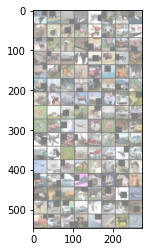

In [7]:
plot_samples(trainloader)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-02


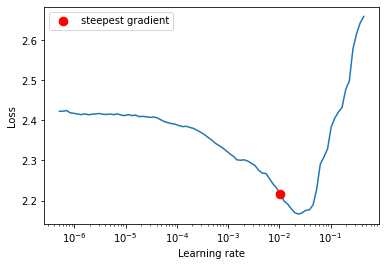

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device=DEVICE)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [9]:
min_loss = min(lr_finder.history['loss'])
min_index = lr_finder.history['loss'].index(min_loss)
lr_value = lr_finder.history['lr'][min_index]
print(lr_value)

0.02364489412645405


In [10]:
# Training loop
optimizer = optim.SGD(model.parameters(), lr=1.45E-02 , momentum=0.9)         #3.85E-02, 2.18E-02
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=.2)
train_loss, train_acc = train_loop(epochs, trainloader, model, DEVICE, optimizer, criterion, scheduler, True)

[1,   391] loss: 564.477
[2,   391] loss: 365.620
[3,   391] loss: 283.869
[4,   391] loss: 237.011
[5,   391] loss: 205.624
[6,   391] loss: 178.488
[7,   391] loss: 159.658
[8,   391] loss: 140.458
[9,   391] loss: 126.344
[10,   391] loss: 112.185
[11,   391] loss: 102.392
[12,   391] loss: 94.397
[13,   391] loss: 84.517
[14,   391] loss: 75.844
[15,   391] loss: 70.953
[16,   391] loss: 63.438
[17,   391] loss: 58.980
[18,   391] loss: 58.023
[19,   391] loss: 52.387
[20,   391] loss: 47.655
[21,   391] loss: 46.433
[22,   391] loss: 41.224
[23,   391] loss: 40.429
[24,   391] loss: 38.889
[25,   391] loss: 36.730
[26,   391] loss: 33.962
[27,   391] loss: 35.270
[28,   391] loss: 31.153
[29,   391] loss: 30.204
[30,   391] loss: 29.460
[31,   391] loss: 27.704
[32,   391] loss: 28.030
[33,   391] loss: 27.274
[34,   391] loss: 17.259
[35,   391] loss: 13.665
[36,   391] loss: 13.510
[37,   391] loss: 11.540
[38,   391] loss: 10.664
[39,   391] loss: 10.451
[40,   391] loss: 9.806

In [11]:
# Test Loop

test_loss, test_acc = test_loop(testloader, model, DEVICE, criterion)
accuracy_per_class(model, classes, testloader, DEVICE)

Accuracy of the network on the 10000 test images: 89 %, Test loss: 1447.745805412531
Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 85 %
Accuracy of   cat : 74 %
Accuracy of  deer : 85 %
Accuracy of   dog : 77 %
Accuracy of  frog : 94 %
Accuracy of horse : 90 %
Accuracy of  ship : 90 %
Accuracy of truck : 90 %


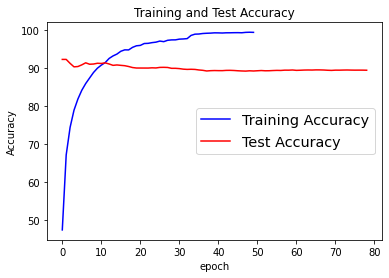

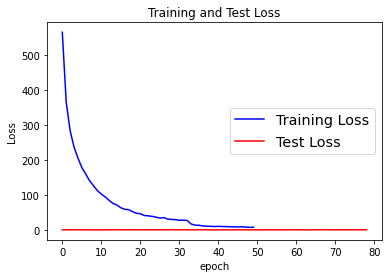

In [12]:
plot_train_vs_test(train_acc, test_acc, 'Accuracy')
plot_train_vs_test(train_loss, test_loss, 'Loss')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


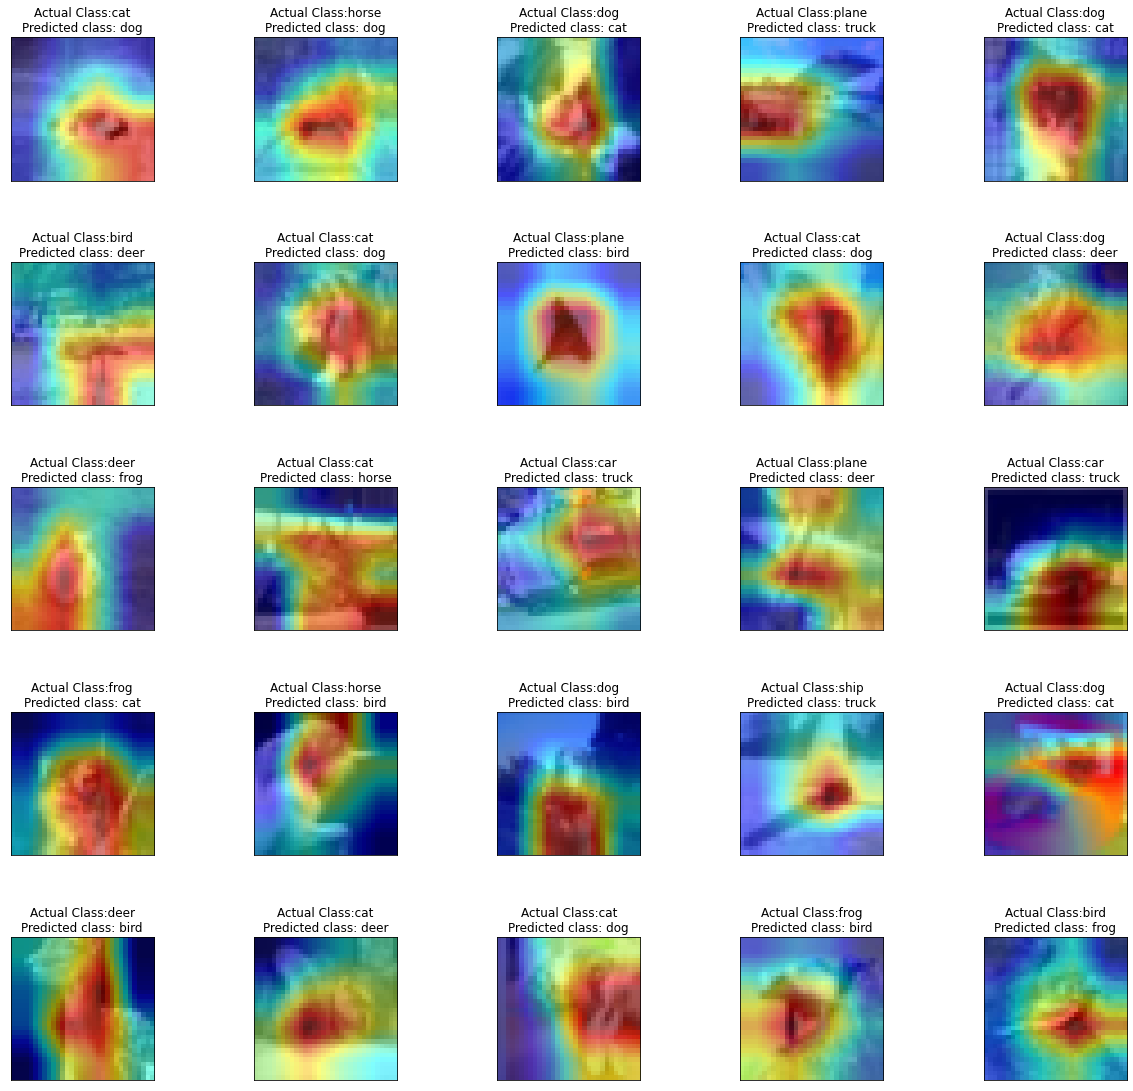

In [13]:
# Show gradcam missclassified images
missclassified = find_misclassified(model, testloader)
plot_misclassified_gradcam(model, missclassified, classes, 'layer4', model_type='resnet')